In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys    
import os
path_to_module = '/content/drive/MyDrive/247pj/'
sys.path.append(path_to_module)
os.chdir(path_to_module)

In [ ]:
%matplotlib inline
import torch
import numpy as np

# get the device, either cuda or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('device type is {}'.format(device))

device type is cuda


In [ ]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [ ]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [ ]:
# #extract subject1
# idx = np.argwhere(person_train_valid == 1)[:, 0]
# X_train_valid_1 = X_train_valid[idx, :, :]
# y_train_valid_1 = y_train_valid[idx]

# idx = np.argwhere(person_test == 1)[:, 0]
# X_test_1 = X_test[idx, :, :]
# y_test_1 = y_test[idx]

In [ ]:
def normalize(array):
  return (array - np.mean(array, axis=0)) / np.std(array, axis=0)
  
#preprocess data
y_train_valid -= 769
y_test -= 769

In [ ]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:300]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y

In [ ]:
## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)



## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

Shape of X after trimming: (2115, 22, 300)
Shape of X after maxpooling: (2115, 22, 150)
Shape of X after averaging+noise and concatenating: (4230, 22, 150)
Shape of X after subsampling and concatenating: (8460, 22, 150)
Shape of X after trimming: (443, 22, 300)
Shape of X after maxpooling: (443, 22, 150)
Shape of X after averaging+noise and concatenating: (886, 22, 150)
Shape of X after subsampling and concatenating: (1772, 22, 150)
(8460, 22, 150)
(8460,)
(1772, 22, 150)
(1772,)
Shape of training set: (6960, 22, 150)
Shape of validation set: (1500, 22, 150)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64
trainset = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).type(torch.LongTensor))
valset = TensorDataset(torch.from_numpy(x_valid).float(), torch.from_numpy(y_valid).type(torch.LongTensor))
testset = TensorDataset(torch.from_numpy(X_test_prep).float(), torch.from_numpy(y_test_prep).type(torch.LongTensor))

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

###CNN###

```
nn.Conv1d(22, 25, 10, padding='same'),
nn.ELU(),
nn.MaxPool1d(3, padding=1),
nn.BatchNorm1d(25),
nn.Dropout(0.5),
nn.Conv1d(25, 50, 10, padding='same'),
nn.ELU(),
nn.MaxPool1d(3, padding=1),
nn.BatchNorm1d(50),
nn.Dropout(0.5),
nn.Conv1d(50, 100, 10, padding='same'),
nn.ELU(),
nn.MaxPool1d(3, padding=1),
nn.BatchNorm1d(100),
nn.Dropout(0.5),
nn.Conv1d(100, 200, 10, padding='same'),
nn.ELU(),
nn.MaxPool1d(3, padding=1),
nn.BatchNorm1d(200),
nn.Dropout(0.5),
nn.Flatten(),
nn.Linear(2600, 4)
```



In [ ]:
import torch.nn as nn # torch neural network modules
class swap(nn.Module):
  def forward(self, x):
    return torch.transpose(x, 1, 2)
class extractcell(nn.Module):
  def forward(self, x):
    out, (hn, cn) = x #out: (N, L=1000, hidden), hn: (#layers, N, hidden)

    return out#[:, :200, :] #(N, L=1000, hidden)

class extractlastcell(nn.Module):
  def forward(self, x):
    out, (hn, cn) = x #out: (N, L=1000, hidden), hn: (#layers, N, hidden)

    return out[:, -1, :] #(N, hidden)

class choosebegin(nn.Module):
  def forward(self, x):
    return x[:, :100, :] 

class CNN_LSTM(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential( #(N, 1000, 22)
            ### 1
            nn.Conv1d(22, 25, 10, padding='same'),
            nn.ELU(alpha=0.9, inplace=True),
            nn.MaxPool1d(3, padding=1),
            nn.BatchNorm1d(25, eps=1e-05, momentum=0.2, affine=True),
            nn.Dropout(0.5),

            nn.Conv1d(25, 50, 10, padding='same'),
            nn.ELU(alpha=0.9, inplace=True),
            nn.MaxPool1d(3, padding=1),
            nn.BatchNorm1d(50, eps=1e-05, momentum=0.2, affine=True),
            nn.Dropout(0.5),

            nn.Conv1d(50, 100, 10, padding='same'),
            nn.ELU(alpha=0.9, inplace=True),
            nn.MaxPool1d(3, padding=1),
            nn.BatchNorm1d(100, eps=1e-05, momentum=0.2, affine=True),
            nn.Dropout(0.5),

            nn.Conv1d(100, 200, 10, padding='same'),
            nn.ELU(alpha=0.9, inplace=True),
            nn.MaxPool1d(3, padding=1),
            nn.BatchNorm1d(200, eps=1e-05, momentum=0.2, affine=True),
            nn.Dropout(0.5),

            swap(),
            nn.LSTM(200, 400, 3, batch_first=True, dropout=0.5), 
            extractcell(),
            swap(),

            nn.Flatten(),
            nn.Linear(800, 4)
        )

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.net(x)

    def cal_loss(self, pred, target):
        return self.criterion(pred, target)

model = CNN_LSTM().to(device)

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt

PATH_loss = './RNN_loss_2.pth'
PATH_acc = './RNN_acc.pth'

def train(tr_set, model, device):

    n_epochs = 80

    # Setup optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_record = {'train':[], 'val':[]}
    acc_record = {'train':[], 'val':[]}
    best_loss = 10
    best_acc = 0
    for epoch in range(n_epochs):
        model.train()
        #running_loss = 0.0
        for data in tr_set:
            optimizer.zero_grad()
            x, y = data
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = model.cal_loss(pred, y)
            loss.backward()
            optimizer.step()
        
        acc_val, loss_val = test(valloader, model, device)
        acc_train, loss_train = test(trainloader, model, device)
        acc_record['val'].append(acc_val)
        loss_record['val'].append(loss_val)
        acc_record['train'].append(acc_train)
        loss_record['train'].append(loss_train)
        print('Finished training after {} epochs'.format(epoch+1))
        print('acc on validation set: {}\n'.format(acc_val))
        if loss_val < best_loss:
          best_loss = loss_val
          # Save:
          torch.save(model.state_dict(), PATH_loss) # save state_dict
        if acc_val > best_acc:
          best_acc = acc_val
          # Save:
          torch.save(model.state_dict(), PATH_acc) # save state_dict
    plt.subplot(2, 1, 1)
    plt.title('loss')
    plt.plot(loss_record['train'], '-', label='train')
    plt.plot(loss_record['val'], '-', label='val')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.subplot(2, 1, 2)
    plt.title('Accuracy')
    plt.plot(acc_record['train'], '-', label='train')
    plt.plot(acc_record['val'], '-', label='val')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.gcf().set_size_inches(15, 12)
    plt.show()

In [ ]:
def test(tt_set, model, device):
    correct = total = loss = 0
    model.eval()
    for x, y in tt_set:
      x, y = x.to(device), y.to(device)
      with torch.no_grad():
        pred = model(x)
        loss += model.cal_loss(pred, y).item() * y.size(0)
        _, predicted = torch.max(pred.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()
    acc = correct / total
    loss /= total
    return acc, loss

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Finished training after 1 epochs
acc on validation set: 0.3953333333333333

Finished training after 2 epochs
acc on validation set: 0.4673333333333333

Finished training after 3 epochs
acc on validation set: 0.5193333333333333

Finished training after 4 epochs
acc on validation set: 0.5686666666666667

Finished training after 5 epochs
acc on validation set: 0.634

Finished training after 6 epochs
acc on validation set: 0.6493333333333333

Finished training after 7 epochs
acc on validation set: 0.656

Finished training after 8 epochs
acc on validation set: 0.682

Finished training after 9 epochs
acc on validation set: 0.7093333333333334

Finished training after 10 epochs
acc on validation set: 0.706

Finished training after 11 epochs
acc on validation set: 0.7253333333333334

Finished training after 12 epochs
acc on validation set: 0.7653333333333333

Finished training after 13 epochs
acc on validation set: 0.7313333333333333

Finished training after 14 epochs
acc on validation set: 0.7

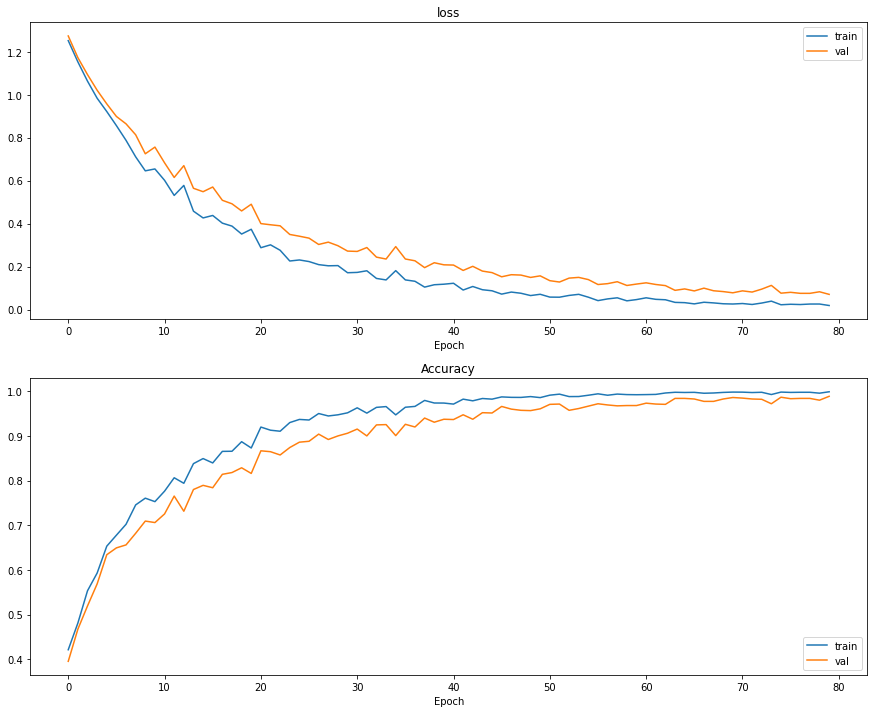

In [ ]:
train(trainloader, model, device)

In [ ]:
best_model_loss = CNN_LSTM()
best_model_loss.load_state_dict(torch.load(PATH_loss)) # load state_dict
best_model_loss.to(device)
best_model_loss.eval() # sets model in evaluation (inference) mode
best_model_acc = CNN_LSTM()
best_model_acc.load_state_dict(torch.load(PATH_acc)) # load state_dict
best_model_acc.to(device)
best_model_acc.eval() # sets model in evaluation (inference) mode

CNN_LSTM(
  (net): Sequential(
    (0): Conv1d(22, 25, kernel_size=(10,), stride=(1,), padding=same)
    (1): ELU(alpha=0.9, inplace=True)
    (2): MaxPool1d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
    (3): BatchNorm1d(25, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv1d(25, 50, kernel_size=(10,), stride=(1,), padding=same)
    (6): ELU(alpha=0.9, inplace=True)
    (7): MaxPool1d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
    (8): BatchNorm1d(50, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (9): Dropout(p=0.5, inplace=False)
    (10): Conv1d(50, 100, kernel_size=(10,), stride=(1,), padding=same)
    (11): ELU(alpha=0.9, inplace=True)
    (12): MaxPool1d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
    (13): BatchNorm1d(100, eps=1e-05, momentum=0.2, affine=True, track_running_stats=True)
    (14): Dropout(p=0.5, inplace=False)
  

In [ ]:
print(test(testloader, best_model_loss, device))
print(test(testloader, best_model_acc, device))
print(test(testloader, model, device))

(0.70372460496614, 1.0050144826585499)
(0.70372460496614, 1.0050144826585499)
(0.70372460496614, 1.0050144826585499)


In [ ]:
time = [200, 250, 300, 400, 500, 750, 1000]
acc = [0.6523702031602708, 0.6845372460496614, 0.70372460496614, 0.6766365688487584, 0.6659142212189616, 0.659706546275395, 0.6426185101580135]

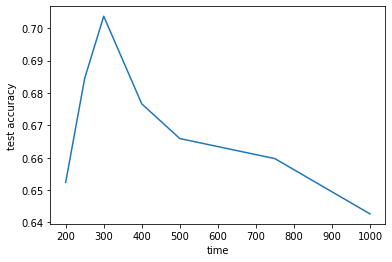

In [ ]:
plt.plot(time, acc, '-')
plt.xlabel('time')
plt.ylabel('test accuracy')
plt.show()